#Instalación de las librerías

In [11]:
!pip install pint

In [12]:
#download modsim.py
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

# Ecuación logística

In [15]:
import modsim as ms
import pandas
from matplotlib import pyplot
import numpy as np

def step(x, t, sistema):
    return x[t] * sistema.b * (1-x[t]) #3.11

### Simulación
def run_simulation(sistema, step_func):
    resultado = ms.TimeSeries()
    resultado[sistema.t_0] = sistema.x_0

    for t in ms.linrange(sistema.t_0, sistema.t_end):
        resultado[t+1] = step_func(resultado, t, sistema)

    return resultado

In [16]:
def plot_elongacion(resultado):
    pyplot.figure(figsize=(16, 6))
    pyplot.xlabel('t')
    pyplot.ylabel('X(t)')
    pyplot.plot(resultado, 'o:b', label="Ec. Logística - Elongación")
    ms.decorate(title='Ec. logística - Diagrama de elongación', xlabel='Tiempo', ylabel='X(t)')

def plot_fase(resultado, sistema):
    pyplot.figure()
  # graficamos la recta a 45º
    p1 = max(1,1)
    p2 = min(0,0)
    pyplot.plot([p1, p2], [p1, p2], 'b-')

    # graficamos la parabola de la ecuacion normalizada
    xx = ms.linspace(0,1,100)
    yy = [ (sistema.b*x*(1-x)) for x in xx]
    pyplot.plot(xx,yy,'-')
    pyplot.xlabel("X(t)")
    pyplot.ylabel("X(t+1)")
    pyplot.title("Ec. logística - Diagrama de fase", fontsize=13)

    # graficar los puntos sobre la parabola
    resultado = resultado.tolist() #resultado que devuelve la simulación
    resultado1 = resultado.copy()
    resultado.pop() #elimino el ultimo elemento
    resultado1.pop(0) # elimino el primer. Población incrementada, vs poblacion actual

    pyplot.plot(resultado,resultado1, 'ro')

Puntos de estabilidad   0.6428571428730687


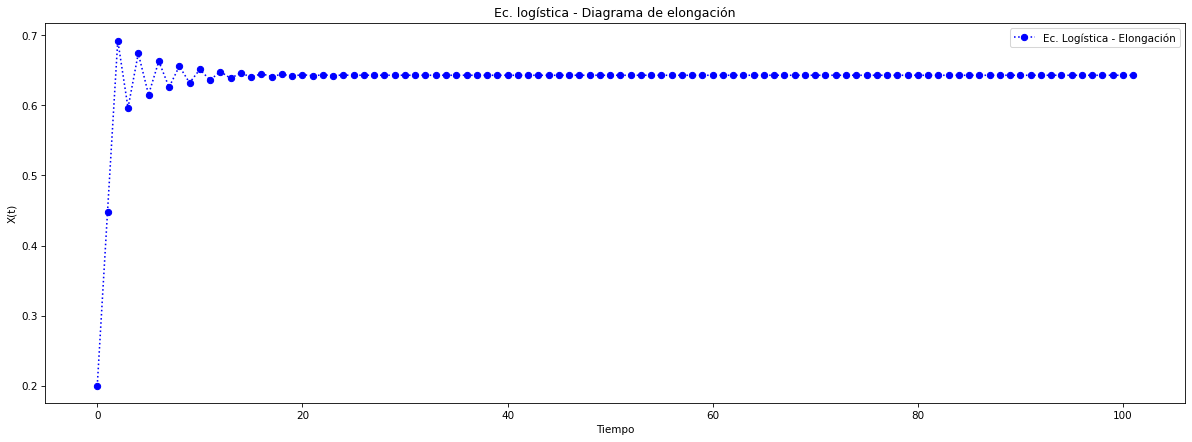

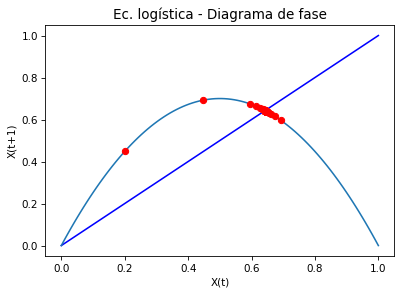

In [25]:
def elong_fase():
    sistema = ms.System(
            x_0 = 0.2,
            t_0 = 0,
            t_end = 100,
            b = 2.8 # podemos ir cambiando
            )

    res = run_simulation(sistema, step)
    plot_elongacion(res)
    plot_fase(res,sistema)
    puntos_estabilidad = res[100]
    #puntos_estabilidad = x_estable(res,20,2)
    print("Puntos de estabilidad  ", puntos_estabilidad)

elong_fase()

###Calcular el punto de estabilidad

In [28]:
def x_estable(res, threshold=20, precision=2): # saco los últimos 20; la precision de los decimales
    ultimos = res[-threshold:]
    #print(ultimos)
    ultimos = [round(x,precision) for x in ultimos] #redondeo cada uno
    print(ultimos)
    estabilidad = list(set(ultimos)) #saco los repetidos
    return estabilidad

Probar con los valores de la teoría.

### Diagramas de Feigenbaum

Es el gráfico de los puntos de estabilidad para valores de **b**



In [29]:
# Feigenbaum---------------------------:

def feigenbaum_v1(s):
    '''
      Calcula los valores de estabilidad de cada simulación para todos los valores de b de 1 a 4
      Guarda los valores de estabilidad del sistema en una lista que luego se grafica.
    '''
    print("Feigenbaum - Diego Córdoba")
    sweep_b = ms.SweepSeries()
    b_array = ms.linspace(s.b1, s.b2, int(s.t_end)) #separados segun las iteraciones que tenga
    for i in b_array:
     #   print("Calculando: ", i)
        s.b=i
        resultado = run_simulation(s,step)
        sweep_b[i] = x_estable(resultado,precision=2)
      #  print(sweep_b[i])

    pyplot.xlabel("b")
    pyplot.ylabel("Punto de estabilidad")

    for b in b_array:
        for est in sweep_b[b]:
                pyplot.scatter(b, est, color='blue', s=0.1) # cada valor de b y los puntos de estabilidad
## --------- ##

def logistica_math(sistema):
    x_array = [sistema.x_0] #crea un array que empieza en cero y por cada valor
    for i in range(int(sistema.t_end)-1):
        x_array.append(sistema.b * x_array[-1]*(1-x_array[-1])) #guardo los valores de la ec. logistica

    return x_array[-int(sistema.t_ultimos):] # retorno los ultimos que es donde hay estabilidad. Arreglo con los puntos de estabilidad

def feigenbaum_v2(s):
  #usa la ecuación logística para calcular valores
    b_array = np.linspace(s.b1,s.b2,int(s.t_end))

    x_estable = []
    b_estable = []
    for sistema.b in b_array:
        x_estable.append(logistica_math(s)) #guardo los valores estables que me devuelve la ecuación anterior para cada valor de b
        b_estable.append([s.b] * int(s.t_ultimos))  #b por la cantidad de ultimos, cdo hago el scatter para que las dos sean de la misma dimension. Le repito los valores de estabilidad para cada b. para tener la misma dimensión

    x_estable = np.array(x_estable).ravel()
    b_estable = np.array(b_estable).ravel()

    print("sizes: ", len(x_estable), len(b_estable))

#para hacer zoom en la gráfica
    x_estable_acotado = []
    b_estable_acotado = []
    for x,b in zip(x_estable,b_estable):
        if x >s.x1 and x<s.x2: #listas que contienen los valores entre los valores que estan dentro del if
            x_estable_acotado.append(x)
            b_estable_acotado.append(b)

    pyplot.figure(figsize=(10, 6))
    pyplot.xlabel('b')
    pyplot.ylabel('x')
    pyplot.scatter(b_estable_acotado, x_estable_acotado, color='red', s=0.01)

sizes:  50000 50000


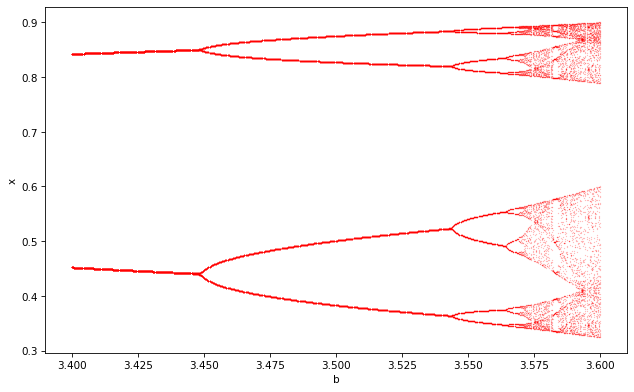

In [30]:
if __name__ == "__main__":

    #elong_fase()

    sistema = ms.System(
            x_0 = 0.2,
            t_0 = 0,
            t_end = 500, #100
            t_ultimos = 100, # para obtener las últimas 100 iteraciones
            b =2.98,
            b1=3.4, #valores de limites de 1 a 4. Se modifican para hacer zoom a la gráfica.
            b2=3.6,
            x1=0, #valores en x para hacer zoom a la gráfica
            x2=1
            )

    #feigenbaum_v1(sistema)
    feigenbaum_v2(sistema)

## Fractales
Son estructuras autosimilares que se repiten infinitamente.\
Los detalles mas pequeños repiten las características de la forma global.\
Son trayectorias complejas, repetitivas y continúan hasta el infinito.

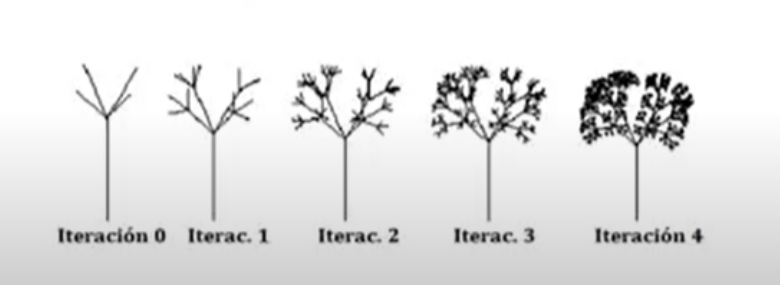

#### Curva de Kolch

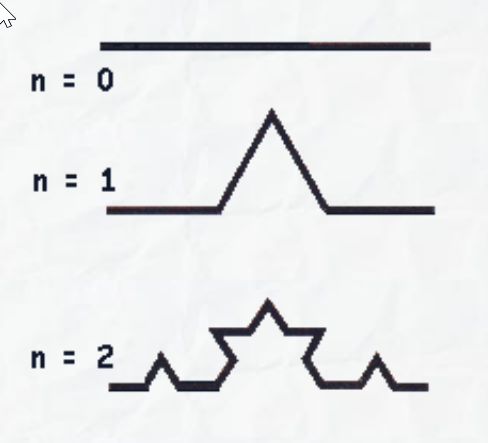

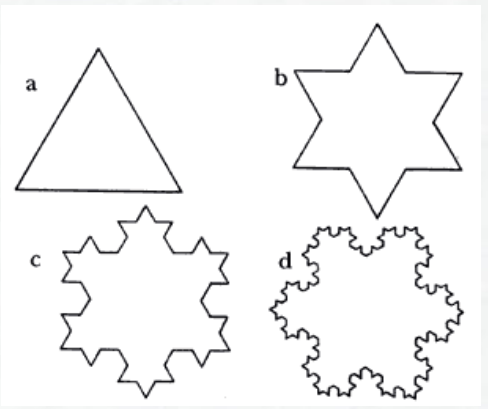

#### Figura de Sierpisnki

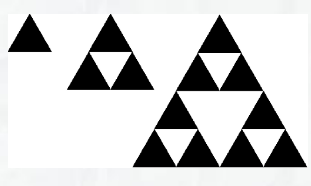